In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
## We will be using BERT for the tweet classification task.  

## Intro to the BERT model
BERT (Bidirectional Encoder Representations from Transformers) is a paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

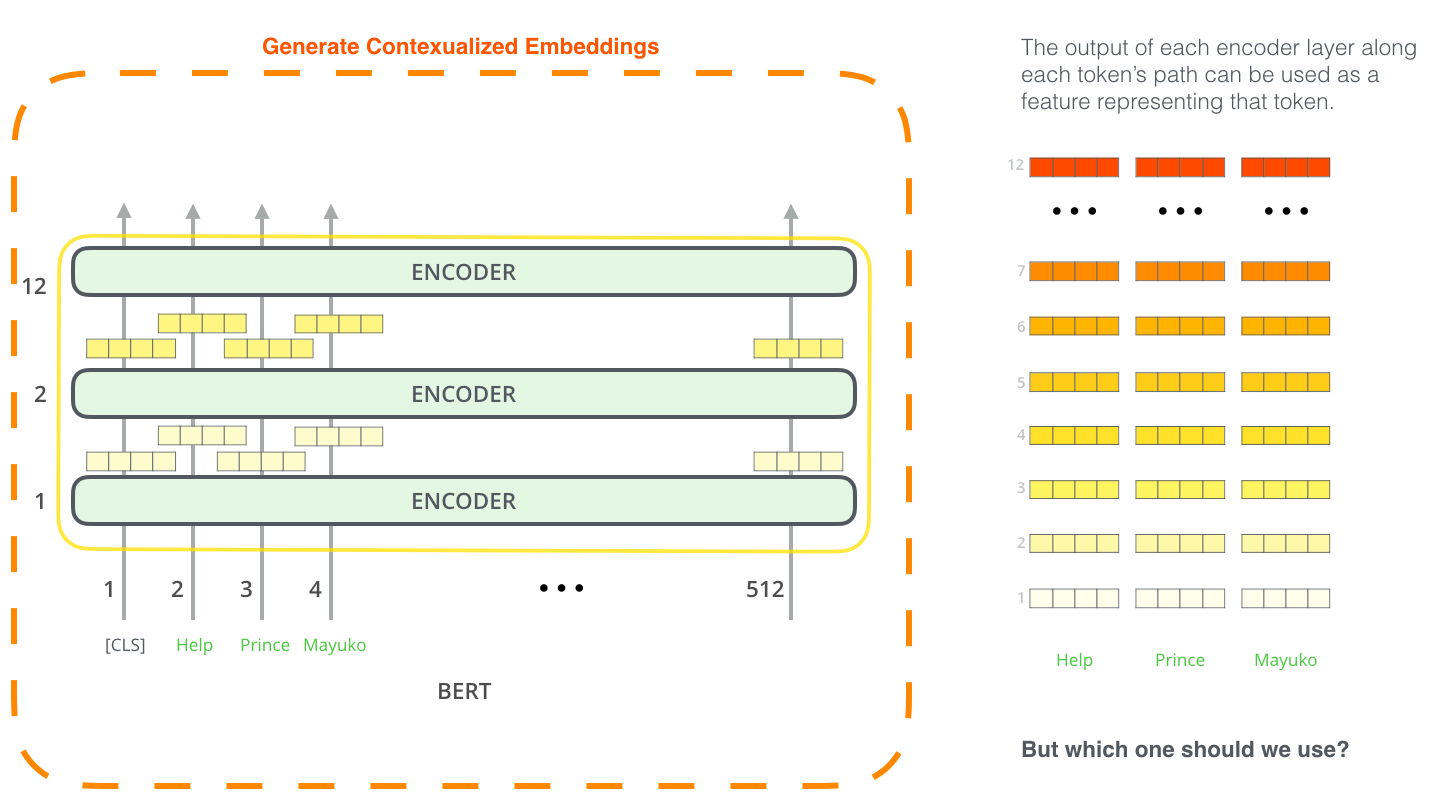




There are multiple pre-trained BERT models available. Later on, we can fine-tune the BERT model to perform the specific tasks such as binary or multi-class classification.

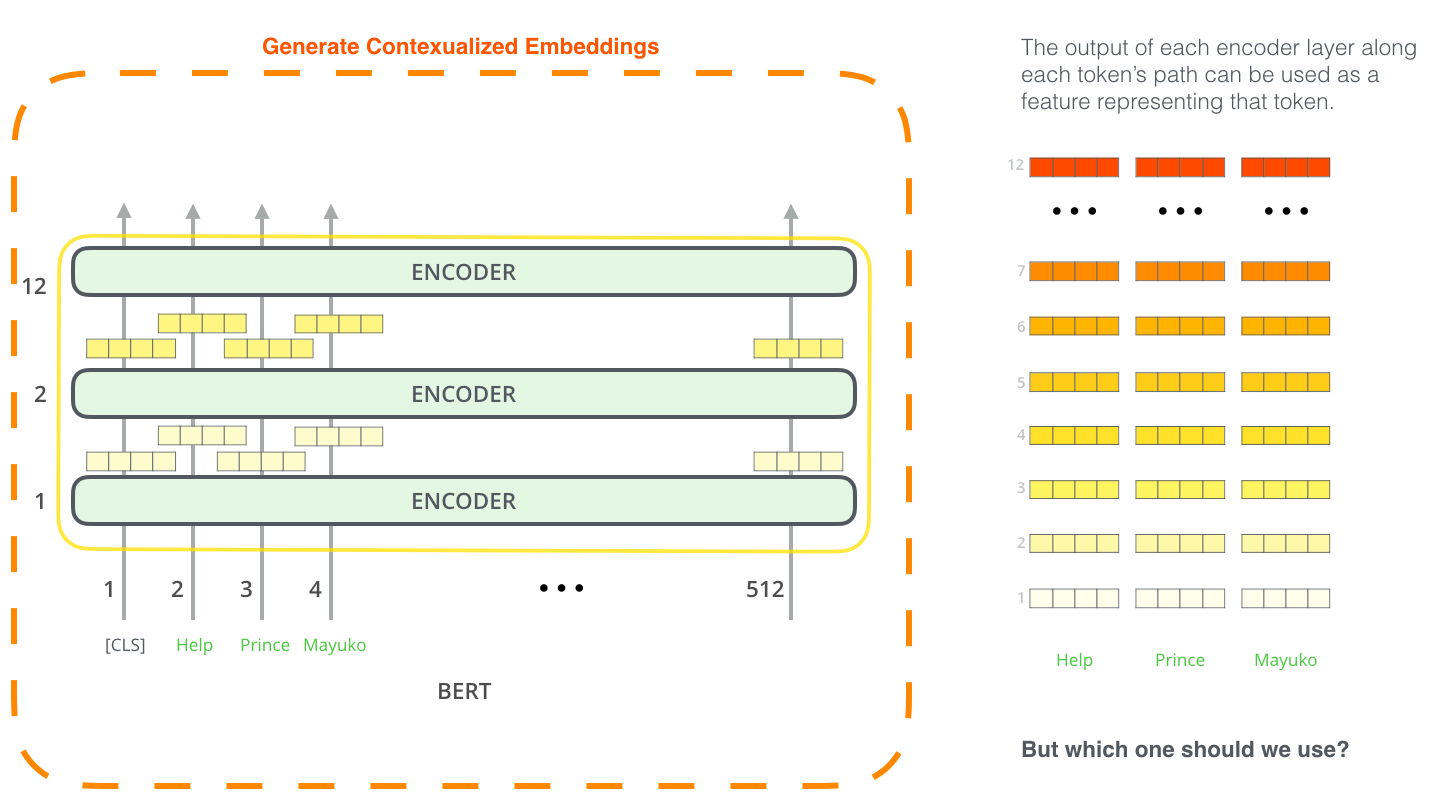


Medium Link:https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

In [ ]:
pip install bert-for-tf2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df_train=pd.read_csv("../input/nlp-getting-started/train.csv")
df_test=pd.read_csv("../input/nlp-getting-started/test.csv")

In [ ]:
df_train.head()

In [ ]:
df_train=df_train.drop(["id","keyword","location"],axis=1)
df_train.head()

In [ ]:
df_train[df_train["target"]==0].head()

In [ ]:
df_train.groupby('target').count().plot.bar()

## Importing the pre-trained model and tokenizer which is specific to BERT

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True, name = 'keras_bert_layer')

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=True

tokenizer_for_bert=bert_tokenization.FullTokenizer(vocab_file,do_lower_case)



In [ ]:
print("The length of the vocab in our tokenizer is:",len(tokenizer_for_bert.vocab))

## Defining helper function for text preprocessig

In [ ]:
def encode_text(texts,tokenizer_for_bert, max_len=512):
    all_token_ids=[]
    all_masks=[]
    all_segments=[]
    
    for text in texts:
        tokens=tokenizer_for_bert.tokenize(text)
        tokens=tokens[:max_len-2]
        input_sequence=["[CLS]"]+tokens+["[SEP]"]
        pad_len=max_len-len(input_sequence)
        token_ids=tokenizer_for_bert.convert_tokens_to_ids(input_sequence)
        token_ids+=[0]*pad_len
        pad_masks=[1]*len(input_sequence)+[0]*pad_len
        segment_ids=[0]*max_len
        
        all_token_ids.append(token_ids)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_token_ids),np.array(all_masks), np.array(all_segments)


In [ ]:
test_text =  "There was a blast in Lebanon the previous day. 130 people are reported to be dead. "

print ("Test text after tokenization: " ,  ["[CLS]"] + tokenizer_for_bert.tokenize( test_text)  + ["[SEP]"] )

print ("Test text after encoding: " ,encode_text( [test_text], tokenizer_for_bert, 7 ) )

## Defining the model

In [ ]:
def bert_model(bert_layer,max_len=512):
    #Input to bert layer
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #Output from bert layer
    bert_layer_out = bert_layer([input_word_ids, input_mask, segment_ids]) # Python list of 2 tensors with shape (batch_size, 768) and (batch_size, max_len, 768)
    
    #Extrating Embedding for CLS token comming out of bert layer. Note CLS is the first token
    cls_out = bert_layer_out[1][:,0,:] # Getting hidden-state of 1st tokens from second tensor in bert_layer_out, Tensor shape - (batch size, 768) 
    
    out = Dense(1, activation='sigmoid')(cls_out)
    
     
    #Model creation using inputs and output
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out, name='deeplearning_bert__model')
    
    
    
    learning_rate = 1e-6 # modify learning rate,as needed
    
    #Compiles Model depending on model type and number of classes. Loss function as well as metrics is used accordingly
    
    model.compile(Adam(lr= learning_rate), loss='binary_crossentropy', metrics=['acc']) # ** For Binary classification
      
    return model

In [ ]:
max_len=40

In [ ]:
model=bert_model(bert_layer,max_len=max_len)

model.summary()

In [ ]:
train_input=encode_text(df_train["text"].values,tokenizer_for_bert,max_len=max_len)

y_train=df["target"].values

In [ ]:
# Let's check the accuracy_score of our BERT model without fine tunig
accuracy_score( y_train, np.round(model.predict(train_input)).flatten() )

## Fine-Tuning the model for tweet classification

In [ ]:
#Model Training (Fine-tuning for tweets classification)
epochs = 5       #Modify as neded
batch_size = 32  #Modify as needed
train_history = model.fit(train_input, y_train ,epochs= epochs,batch_size= batch_size, verbose=1)

In [ ]:
# Now, let us test some tweets and classify them 
tweet="Israel striked Iran as the reply to the attack by Iran and Syria"

prediction=model.predict(encode_text([tweet],tokenizer_for_bert,
                                    max_len=max_len))

print ( 'Tweet Type: ', np.where(  prediction >= .5 , "Disaster", "Non Disaster" ) ,
       '   Score:',  prediction)

In [ ]:

tweet = "Let's go and have some fun at the beach party orrganised by Akshat"

prediction = model.predict (  encode_text( [tweet], tokenizer_for_bert, max_len=max_len) ) 
print('Tweet Text: ', tweet)
print ( 'Tweet Type: ', np.where(  prediction >= .5 , "Disaster", "Non Disaster" ) , '   Score:',  prediction)